# Import librairies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [2]:
data = pd.read_csv('df_rio_interpolado.csv')

In [3]:
data.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [4]:
scaler = MinMaxScaler()

In [5]:
# Ajustar o scaler e transformar os dados na coluna TEMP
scaled_data = scaler.fit_transform(data[['TEMP']])

In [6]:
# Salvar o scaler para uso posterior (por exemplo, para reverter a padronização)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [7]:
# Verificar os dados padronizados
print(data.head())

    TEMP
0  27.73
1  27.97
2  25.70
3  26.49
4  22.42


## Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [9]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [10]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [11]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [12]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = scaled_data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [13]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


## Ajuste dos dados para os modelos LSTM e CNN

In [61]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [ ]:
epochs_mlp = 30
batch = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp.summary()

In [ ]:
history_mlp = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

### Implementacao e Ajuste do Modelo MLP com regularização

In [ ]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_reg.summary()

In [ ]:
history_mlp_reg = model_mlp_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

### Implementacao e ajuste do modelo MLP com Dropout

In [ ]:
model_mlp_dropout = Sequential()
model_mlp_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_dropout.add(Dropout(0.3))  
model_mlp_dropout.add(Dense(32, activation='relu'))
model_mlp_dropout.add(Dropout(0.3))  
model_mlp_dropout.add(Dense(1))  
model_mlp_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_dropout.summary()



In [ ]:
history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [ ]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train, 
                                              Y_train, 
                                              validation_data=(X_valid, Y_valid), 
                                              epochs=epochs_mlp, 
                                              batch_size=32, 
                                              verbose=1)


## Comparando os 4 modelos

In [ ]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
    accuracy = 100 - mape  # Interpretação da acurácia como "100 - MAPE"
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"Acurácia: {accuracy:.2f}%")
    
    return mae, mse, rmse, mape, accuracy

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard, acc_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg, acc_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout, acc_dropout = evaluate_model(model_mlp_dropout, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop, acc_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}, MAPE: {mape_standard:.4f}%, Acurácia: {acc_standard:.2f}%")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}, MAPE: {mape_reg:.4f}%, Acurácia: {acc_reg:.2f}%")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}, MAPE: {mape_dropout:.4f}%, Acurácia: {acc_dropout:.2f}%")
print(f"Modelo com Regularização e Dropout - MAE: {mae_reg_drop:.4f}, RMSE: {rmse_reg_drop:.4f}, MAPE: {mape_reg_drop:.4f}%, Acurácia: {acc_reg_drop:.2f}%")


In [ ]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_mlp.history['loss'], label='Treinamento')
plt.plot(history_mlp.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_mlp_reg.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_mlp_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_mlp_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_dropout.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

In [ ]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Pre-processamento dos Dados

In [14]:
#Hiperparametros
epochs_cnn = 30
batch = 32
lr = 0.001
#adam = optimizers.Adam(lr)


## Implementando e Ajustando Modelo CNN

In [16]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn.summary()

In [17]:
history_cnn = model_cnn.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs_cnn, 
                            verbose=2)

Epoch 1/30
11/11 - 2s - 163ms/step - loss: 0.0616 - val_loss: 0.0152
Epoch 2/30
11/11 - 0s - 8ms/step - loss: 0.0163 - val_loss: 0.0112
Epoch 3/30
11/11 - 0s - 7ms/step - loss: 0.0162 - val_loss: 0.0129
Epoch 4/30
11/11 - 0s - 8ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 5/30
11/11 - 0s - 8ms/step - loss: 0.0146 - val_loss: 0.0123
Epoch 6/30
11/11 - 0s - 8ms/step - loss: 0.0138 - val_loss: 0.0111
Epoch 7/30
11/11 - 0s - 8ms/step - loss: 0.0133 - val_loss: 0.0104
Epoch 8/30
11/11 - 0s - 8ms/step - loss: 0.0130 - val_loss: 0.0098
Epoch 9/30
11/11 - 0s - 8ms/step - loss: 0.0126 - val_loss: 0.0092
Epoch 10/30
11/11 - 0s - 8ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 11/30
11/11 - 0s - 8ms/step - loss: 0.0118 - val_loss: 0.0087
Epoch 12/30
11/11 - 0s - 8ms/step - loss: 0.0114 - val_loss: 0.0091
Epoch 13/30
11/11 - 0s - 15ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 14/30
11/11 - 0s - 9ms/step - loss: 0.0104 - val_loss: 0.0093
Epoch 15/30
11/11 - 0s - 8ms/step - loss: 0.0100 - val

## Implementando e Ajustando Modelo CNN com Regularização L2

In [18]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_reg.summary()


In [19]:
history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs_cnn, 
                            verbose=2)

Epoch 1/30
11/11 - 2s - 158ms/step - loss: 0.8857 - val_loss: 0.6438
Epoch 2/30
11/11 - 0s - 8ms/step - loss: 0.5247 - val_loss: 0.3871
Epoch 3/30
11/11 - 0s - 8ms/step - loss: 0.3228 - val_loss: 0.2428
Epoch 4/30
11/11 - 0s - 8ms/step - loss: 0.2065 - val_loss: 0.1616
Epoch 5/30
11/11 - 0s - 8ms/step - loss: 0.1425 - val_loss: 0.1160
Epoch 6/30
11/11 - 0s - 8ms/step - loss: 0.1070 - val_loss: 0.0899
Epoch 7/30
11/11 - 0s - 10ms/step - loss: 0.0863 - val_loss: 0.0734
Epoch 8/30
11/11 - 0s - 9ms/step - loss: 0.0719 - val_loss: 0.0619
Epoch 9/30
11/11 - 0s - 10ms/step - loss: 0.0622 - val_loss: 0.0529
Epoch 10/30
11/11 - 0s - 11ms/step - loss: 0.0538 - val_loss: 0.0462
Epoch 11/30
11/11 - 0s - 8ms/step - loss: 0.0475 - val_loss: 0.0409
Epoch 12/30
11/11 - 0s - 12ms/step - loss: 0.0427 - val_loss: 0.0366
Epoch 13/30
11/11 - 0s - 8ms/step - loss: 0.0386 - val_loss: 0.0331
Epoch 14/30
11/11 - 0s - 8ms/step - loss: 0.0354 - val_loss: 0.0303
Epoch 15/30
11/11 - 0s - 8ms/step - loss: 0.0328 - 

## Implementando e Ajustando Modelo CNN com Dropout

In [20]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_drop.summary()

In [21]:
history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train, 
                                       validation_data=(X_valid_series, Y_valid), 
                                       epochs=epochs_cnn, 
                                       verbose=2)


Epoch 1/30
11/11 - 2s - 139ms/step - loss: 0.0704 - val_loss: 0.0385
Epoch 2/30
11/11 - 0s - 10ms/step - loss: 0.0297 - val_loss: 0.0112
Epoch 3/30
11/11 - 0s - 10ms/step - loss: 0.0257 - val_loss: 0.0108
Epoch 4/30
11/11 - 0s - 9ms/step - loss: 0.0229 - val_loss: 0.0116
Epoch 5/30
11/11 - 0s - 9ms/step - loss: 0.0217 - val_loss: 0.0103
Epoch 6/30
11/11 - 0s - 9ms/step - loss: 0.0210 - val_loss: 0.0093
Epoch 7/30
11/11 - 0s - 8ms/step - loss: 0.0204 - val_loss: 0.0086
Epoch 8/30
11/11 - 0s - 9ms/step - loss: 0.0211 - val_loss: 0.0086
Epoch 9/30
11/11 - 0s - 9ms/step - loss: 0.0203 - val_loss: 0.0091
Epoch 10/30
11/11 - 0s - 8ms/step - loss: 0.0193 - val_loss: 0.0077
Epoch 11/30
11/11 - 0s - 15ms/step - loss: 0.0192 - val_loss: 0.0082
Epoch 12/30
11/11 - 0s - 27ms/step - loss: 0.0158 - val_loss: 0.0077
Epoch 13/30
11/11 - 0s - 8ms/step - loss: 0.0164 - val_loss: 0.0072
Epoch 14/30
11/11 - 0s - 8ms/step - loss: 0.0175 - val_loss: 0.0072
Epoch 15/30
11/11 - 0s - 16ms/step - loss: 0.0188 -

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [22]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam())
# model_cnn_reg_drop.summary()

In [23]:
history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train, 
                                             validation_data=(X_valid_series, Y_valid), 
                                             epochs=epochs_cnn, 
                                             verbose=2)


Epoch 1/30
11/11 - 2s - 197ms/step - loss: 0.8742 - val_loss: 0.6378
Epoch 2/30
11/11 - 0s - 13ms/step - loss: 0.5349 - val_loss: 0.3846
Epoch 3/30
11/11 - 0s - 14ms/step - loss: 0.3259 - val_loss: 0.2379
Epoch 4/30
11/11 - 0s - 9ms/step - loss: 0.2090 - val_loss: 0.1507
Epoch 5/30
11/11 - 0s - 13ms/step - loss: 0.1415 - val_loss: 0.1062
Epoch 6/30
11/11 - 0s - 10ms/step - loss: 0.1071 - val_loss: 0.0822
Epoch 7/30
11/11 - 0s - 8ms/step - loss: 0.0852 - val_loss: 0.0657
Epoch 8/30
11/11 - 0s - 9ms/step - loss: 0.0712 - val_loss: 0.0579
Epoch 9/30
11/11 - 0s - 9ms/step - loss: 0.0633 - val_loss: 0.0504
Epoch 10/30
11/11 - 0s - 8ms/step - loss: 0.0573 - val_loss: 0.0443
Epoch 11/30
11/11 - 0s - 9ms/step - loss: 0.0537 - val_loss: 0.0377
Epoch 12/30
11/11 - 0s - 15ms/step - loss: 0.0470 - val_loss: 0.0353
Epoch 13/30
11/11 - 0s - 11ms/step - loss: 0.0440 - val_loss: 0.0331
Epoch 14/30
11/11 - 0s - 10ms/step - loss: 0.0391 - val_loss: 0.0286
Epoch 15/30
11/11 - 0s - 15ms/step - loss: 0.036

## Comparando os 4 Modelos CNN

In [24]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EEA1332E80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [25]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo Simples": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn),
        "MSE": mean_squared_error(Y_test, y_pred_cnn),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn)
    },
    "Modelo com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_reg),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_reg),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_reg)
    },
    "Modelo com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_drop)
    },
    "Modelo com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_reg_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_reg_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_reg_drop)
    }
}

# Adicionar a acurácia com base no MAPE
for model, values in metrics.items():
    values["Acurácia"] = 100 - values["MAPE"]  # Calcula a acurácia como 100 - MAPE

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}, Acurácia={values['Acurácia']:.2f}%")


Modelo Simples: MAPE=20.25%, MSE=0.0091, RMSE=0.0954, Acurácia=79.75%
Modelo com Regularização: MAPE=18.33%, MSE=0.0097, RMSE=0.0984, Acurácia=81.67%
Modelo com Dropout: MAPE=19.15%, MSE=0.0082, RMSE=0.0904, Acurácia=80.85%
Modelo com Regularização e Dropout: MAPE=18.87%, MSE=0.0090, RMSE=0.0949, Acurácia=81.13%


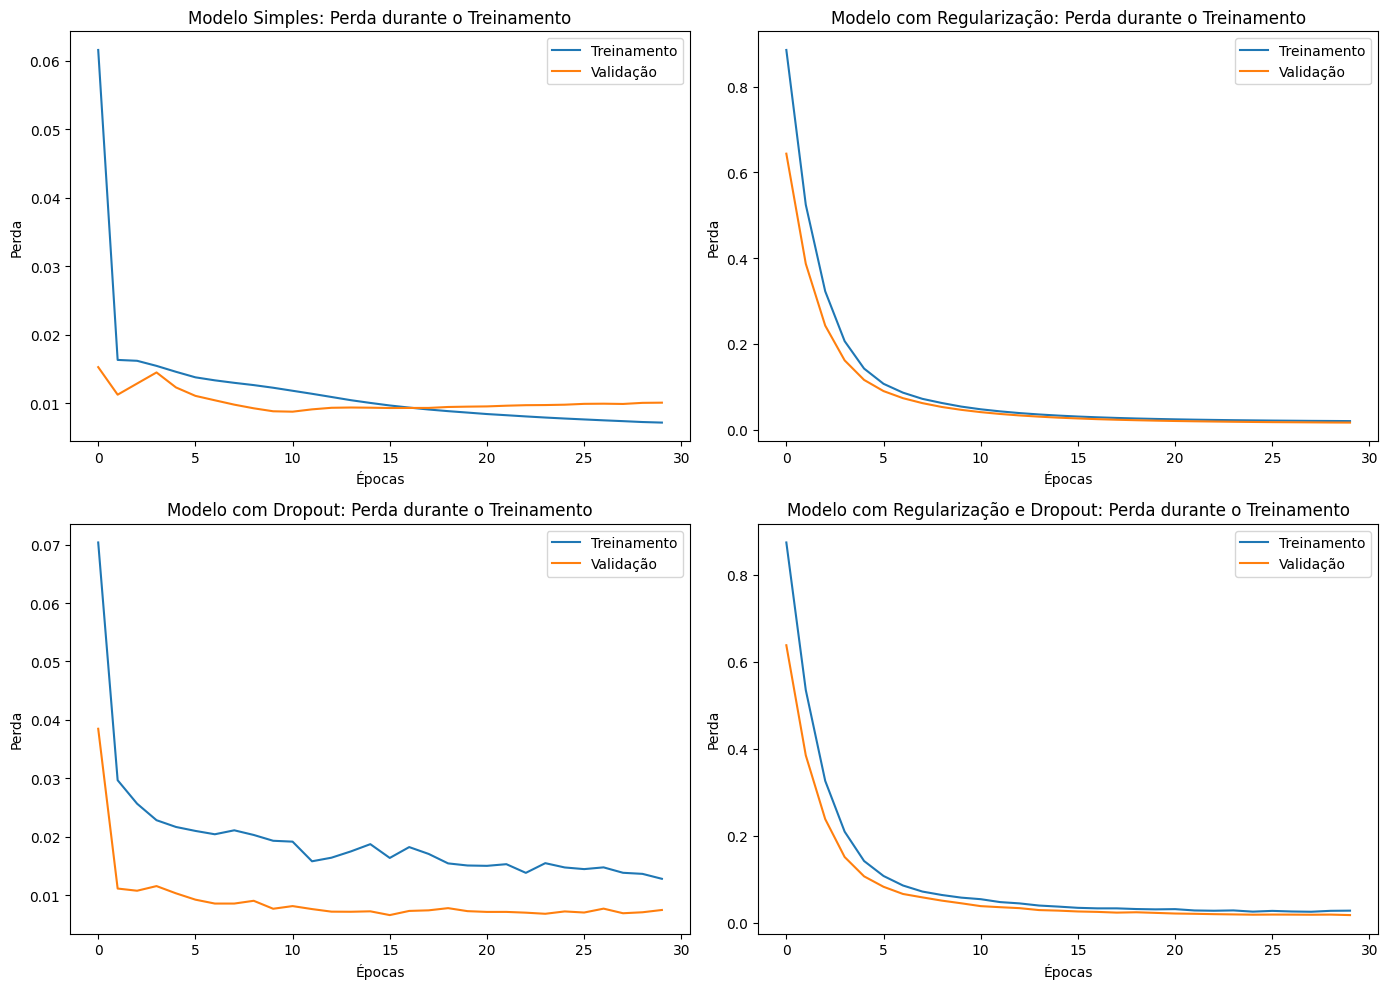

In [26]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


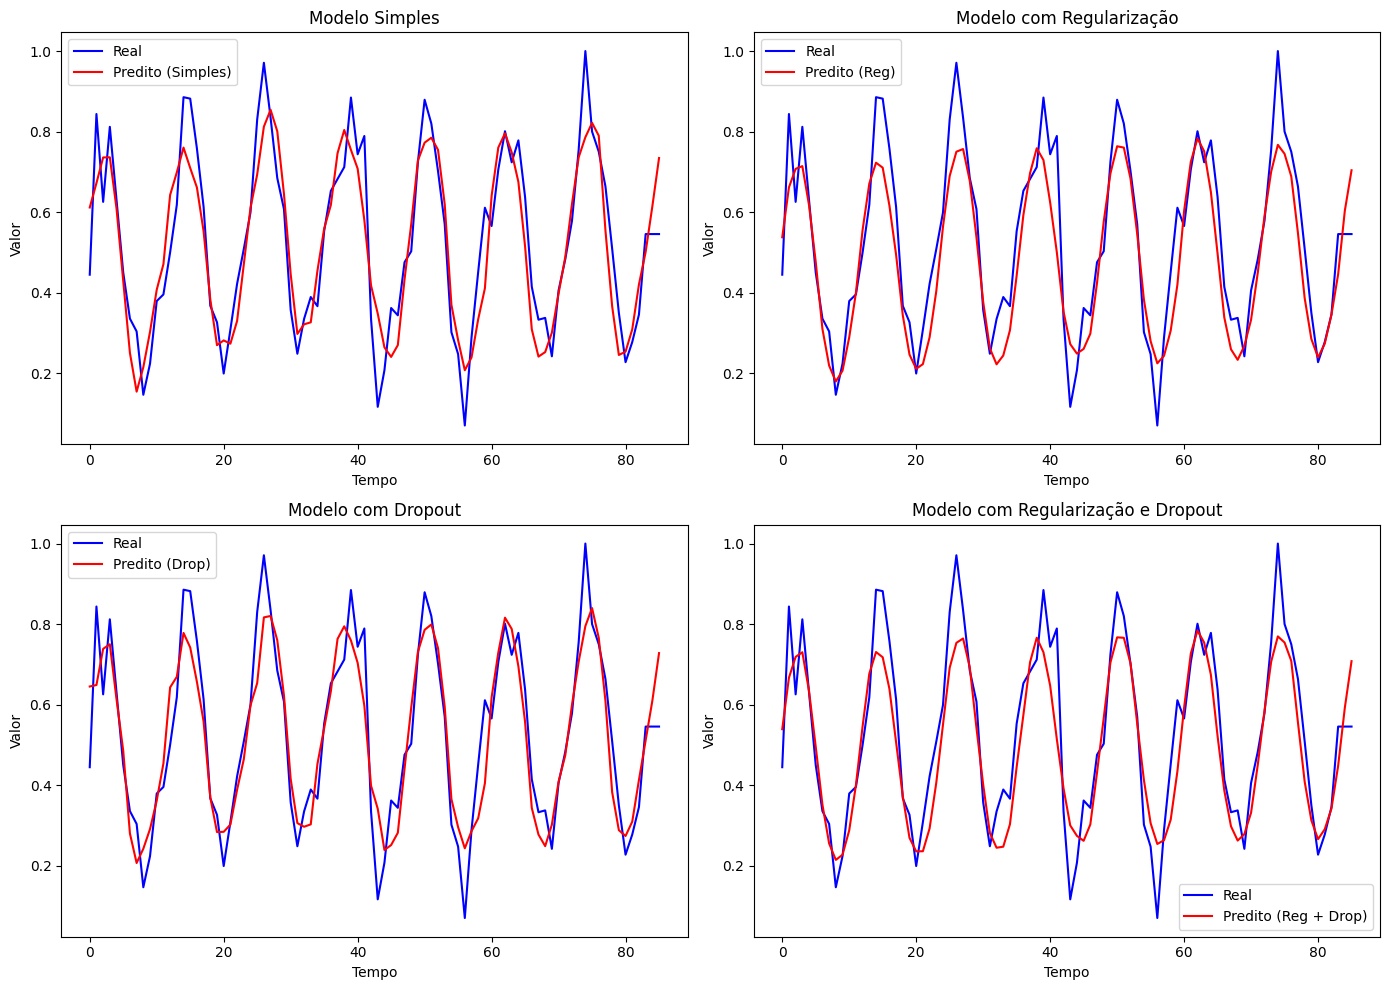

In [27]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


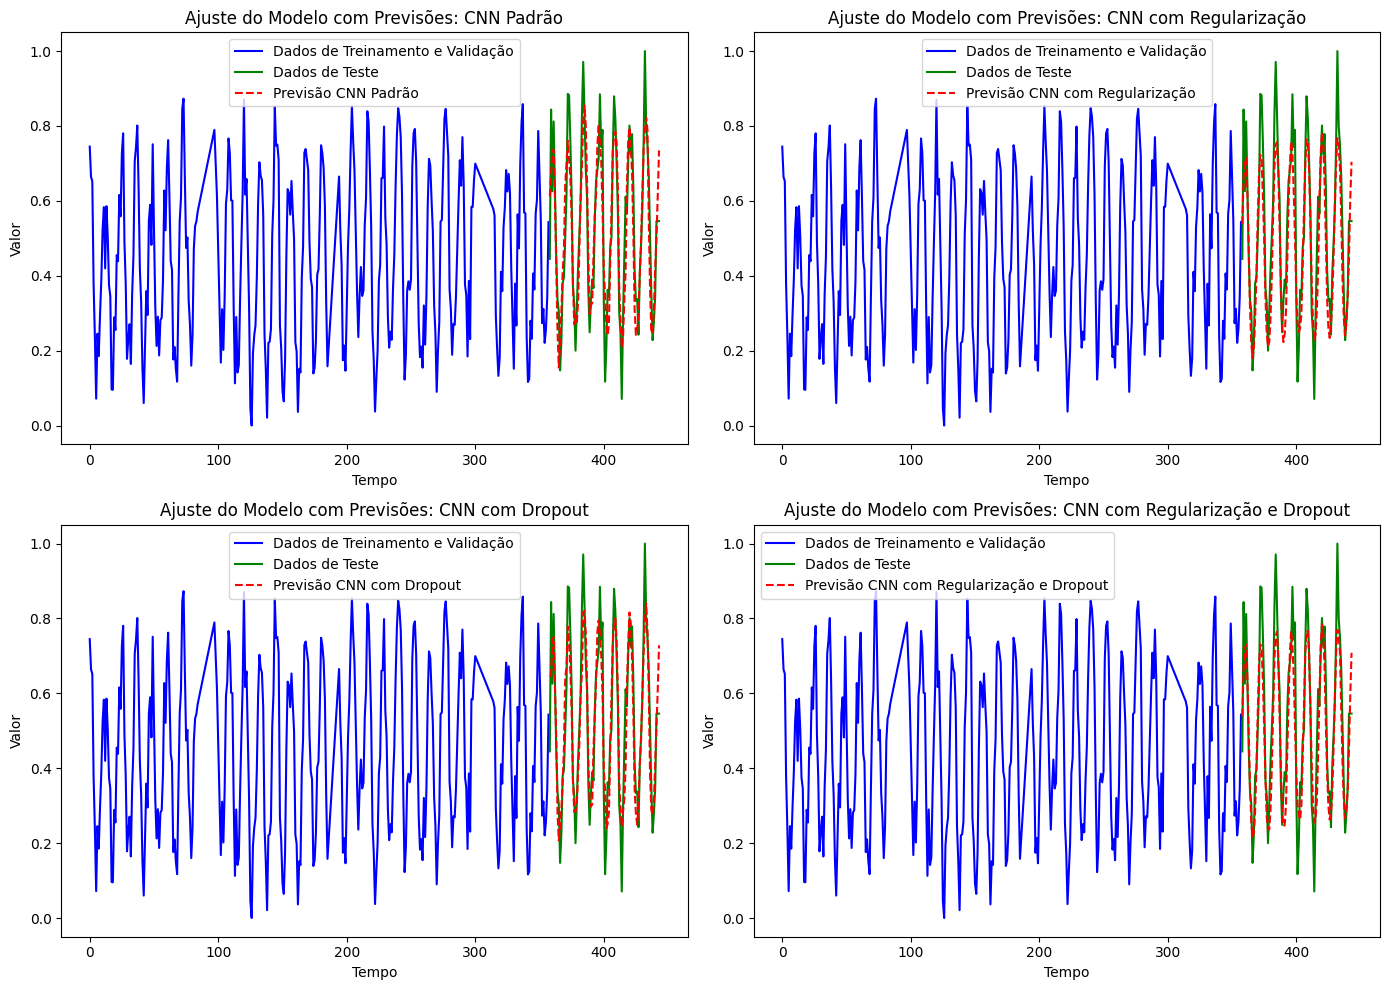

In [28]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [46]:
#Hiperparametros
epochs_lstm = 50
batch = 32
lr = 0.001
adam2 = optimizers.Adam(lr)

In [ ]:
# def create_sequences(data, seq_length):
#     sequences = []
#     labels = []
#     for i in range(len(data) - seq_length):
#         sequence = data[i:i+seq_length]
#         label = data[i+seq_length]
#         sequences.append(sequence)
#         labels.append(label)
#     return np.array(sequences), np.array(labels)

# # Defina o comprimento da sequência
# seq_length = 30 
# x_train, y_train = create_sequences(scaled_data, seq_length)
# print('Train set shape', x_train.shape)
# print('Validation set shape', X_valid.shape)
# print('Test set shape', X_test.shape)

Train set shape (534, 30, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


## Implementacao e Ajuste do Modelo LSTM

In [48]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam())
#model_lstm.summary()

In [49]:
history_lstm = model_lstm.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              epochs=epochs_lstm,
                                verbose=2)

Epoch 1/50
11/11 - 3s - 262ms/step - loss: 0.2112 - val_loss: 0.1459
Epoch 2/50
11/11 - 0s - 20ms/step - loss: 0.1009 - val_loss: 0.0493
Epoch 3/50
11/11 - 0s - 20ms/step - loss: 0.0517 - val_loss: 0.0490
Epoch 4/50
11/11 - 0s - 19ms/step - loss: 0.0483 - val_loss: 0.0486
Epoch 5/50
11/11 - 0s - 20ms/step - loss: 0.0459 - val_loss: 0.0474
Epoch 6/50
11/11 - 0s - 20ms/step - loss: 0.0443 - val_loss: 0.0459
Epoch 7/50
11/11 - 0s - 20ms/step - loss: 0.0434 - val_loss: 0.0447
Epoch 8/50
11/11 - 0s - 20ms/step - loss: 0.0421 - val_loss: 0.0434
Epoch 9/50
11/11 - 0s - 20ms/step - loss: 0.0408 - val_loss: 0.0416
Epoch 10/50
11/11 - 0s - 20ms/step - loss: 0.0386 - val_loss: 0.0390
Epoch 11/50
11/11 - 0s - 20ms/step - loss: 0.0366 - val_loss: 0.0366
Epoch 12/50
11/11 - 0s - 20ms/step - loss: 0.0337 - val_loss: 0.0362
Epoch 13/50
11/11 - 0s - 20ms/step - loss: 0.0310 - val_loss: 0.0404
Epoch 14/50
11/11 - 0s - 30ms/step - loss: 0.0386 - val_loss: 0.0342
Epoch 15/50
11/11 - 0s - 19ms/step - loss:

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [50]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(), loss='mse')
#model_lstm_reg.summary()


In [51]:
# Treinamento do modelo com regularização L2
# history_lstm_reg = model_lstm_reg.fit(X_train_series, 
#                                       y_train, 
#                                       epochs=epochs_lstm, 
#                                       batch_size=32, 
#                                       validation_split= 0.15, 
#                                       verbose=2)

history_lstm_reg = model_lstm_reg.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              epochs=epochs_lstm,
                                verbose=2)


Epoch 1/50
11/11 - 3s - 230ms/step - loss: 0.2247 - val_loss: 0.1689
Epoch 2/50
11/11 - 0s - 21ms/step - loss: 0.1308 - val_loss: 0.0738
Epoch 3/50
11/11 - 0s - 20ms/step - loss: 0.0678 - val_loss: 0.0593
Epoch 4/50
11/11 - 0s - 20ms/step - loss: 0.0598 - val_loss: 0.0604
Epoch 5/50
11/11 - 0s - 19ms/step - loss: 0.0565 - val_loss: 0.0564
Epoch 6/50
11/11 - 0s - 21ms/step - loss: 0.0539 - val_loss: 0.0543
Epoch 7/50
11/11 - 0s - 21ms/step - loss: 0.0520 - val_loss: 0.0527
Epoch 8/50
11/11 - 0s - 20ms/step - loss: 0.0504 - val_loss: 0.0511
Epoch 9/50
11/11 - 0s - 19ms/step - loss: 0.0487 - val_loss: 0.0494
Epoch 10/50
11/11 - 0s - 19ms/step - loss: 0.0472 - val_loss: 0.0477
Epoch 11/50
11/11 - 0s - 21ms/step - loss: 0.0455 - val_loss: 0.0458
Epoch 12/50
11/11 - 0s - 21ms/step - loss: 0.0439 - val_loss: 0.0437
Epoch 13/50
11/11 - 0s - 21ms/step - loss: 0.0422 - val_loss: 0.0415
Epoch 14/50
11/11 - 0s - 21ms/step - loss: 0.0405 - val_loss: 0.0394
Epoch 15/50
11/11 - 0s - 21ms/step - loss:

## Implementacao e Ajuste do Modelo LSTM com Dropout

In [52]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(), loss='mse')
#model_lstm_dropout.summary()


In [53]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series, 
                                              Y_train, 
                                              epochs=epochs_lstm, 
                                              batch_size=32, 
                                              validation_data=(X_valid, Y_valid), 
                                              verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.3186 - val_loss: 0.2186
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2036 - val_loss: 0.1223
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1004 - val_loss: 0.0552
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0590 - val_loss: 0.0505
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0596 - val_loss: 0.0469
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0541 - val_loss: 0.0457
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0478 - val_loss: 0.0454
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0531 - val_loss: 0.0441
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0512 - val_loss: 0.0436
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0481 - val_loss: 0.0423
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0439 - val_loss: 0.0421
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [54]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        50, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3)) 
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam())
#model_lstm_reg_dropout.summary()


In [55]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series, 
                            Y_train, 
                            epochs=epochs_lstm,
                            batch_size=32, 
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

# history_lstm_drop = model_lstm_drop.fit(X_train_series, 
#                                               Y_train, 
#                                               epochs=epochs_lstm, 
#                                               batch_size=32, 
#                                               validation_data=(X_valid_series, Y_valid), 
#                                               verbose=1)

Epoch 1/50
11/11 - 3s - 254ms/step - loss: 0.2137 - val_loss: 0.1312
Epoch 2/50
11/11 - 0s - 39ms/step - loss: 0.0948 - val_loss: 0.0741
Epoch 3/50
11/11 - 0s - 28ms/step - loss: 0.0740 - val_loss: 0.0639
Epoch 4/50
11/11 - 0s - 21ms/step - loss: 0.0665 - val_loss: 0.0603
Epoch 5/50
11/11 - 0s - 20ms/step - loss: 0.0605 - val_loss: 0.0579
Epoch 6/50
11/11 - 0s - 20ms/step - loss: 0.0590 - val_loss: 0.0563
Epoch 7/50
11/11 - 0s - 20ms/step - loss: 0.0584 - val_loss: 0.0549
Epoch 8/50
11/11 - 0s - 20ms/step - loss: 0.0581 - val_loss: 0.0537
Epoch 9/50
11/11 - 0s - 21ms/step - loss: 0.0584 - val_loss: 0.0528
Epoch 10/50
11/11 - 0s - 20ms/step - loss: 0.0584 - val_loss: 0.0517
Epoch 11/50
11/11 - 0s - 20ms/step - loss: 0.0530 - val_loss: 0.0509
Epoch 12/50
11/11 - 0s - 20ms/step - loss: 0.0528 - val_loss: 0.0500
Epoch 13/50
11/11 - 0s - 20ms/step - loss: 0.0541 - val_loss: 0.0494
Epoch 14/50
11/11 - 0s - 21ms/step - loss: 0.0505 - val_loss: 0.0488
Epoch 15/50
11/11 - 0s - 21ms/step - loss:

## Comparativo entre os modelos - Predicao e Validacao

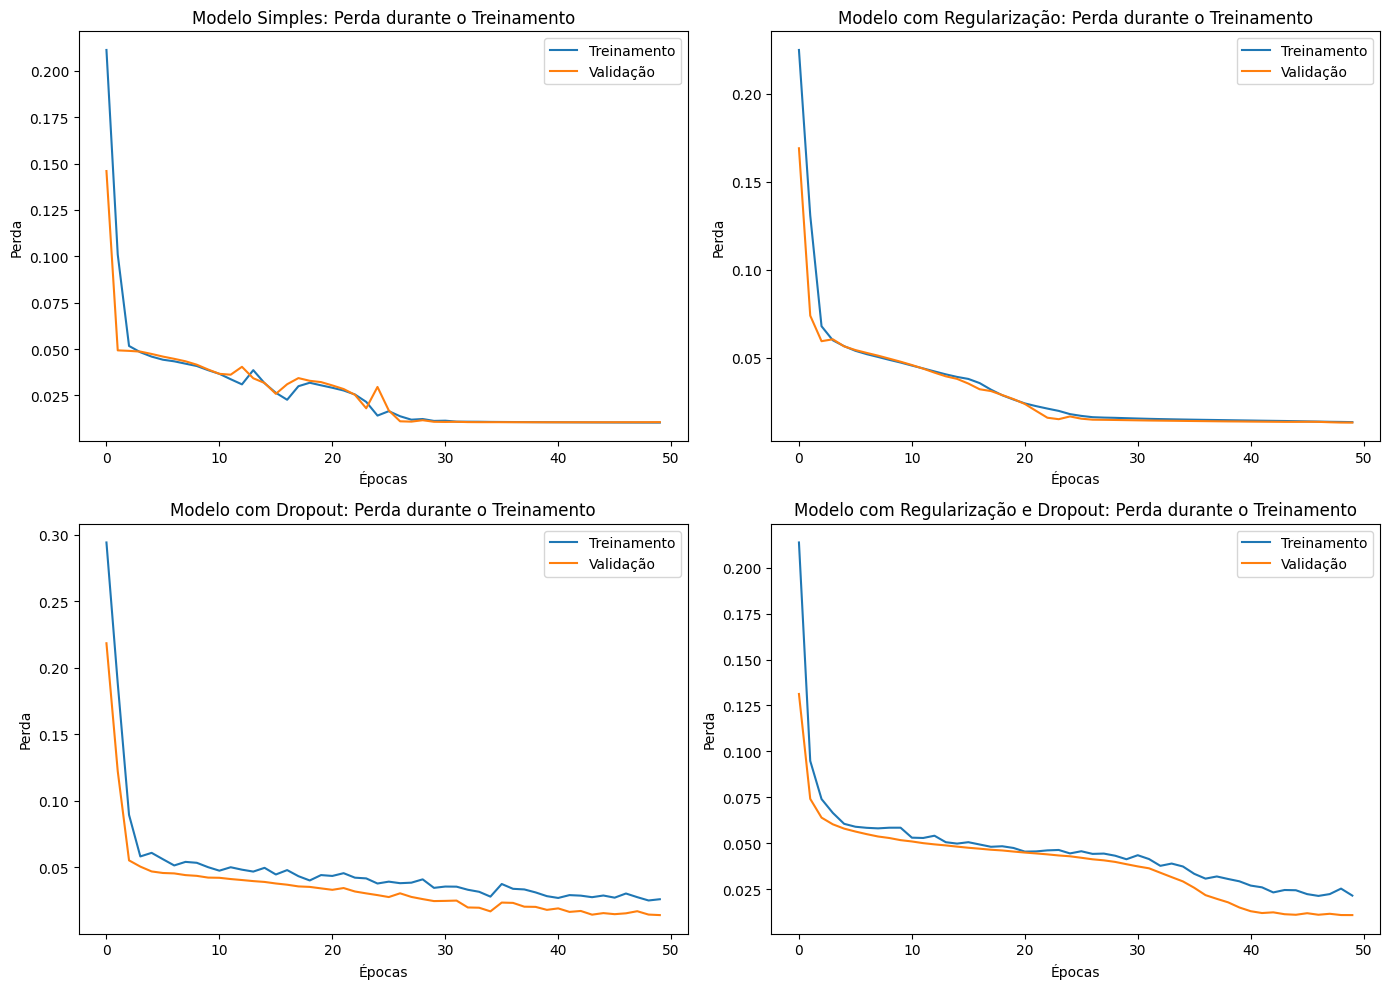

In [56]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['loss'], label='Treinamento')
plt.plot(history_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


In [58]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo LSTM": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm),
        "MSE": mean_squared_error(Y_test, y_pred_lstm),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm)
    },
    "Modelo LSTM com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm_reg),
        "MSE": mean_squared_error(Y_test, y_pred_lstm_reg),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm_reg)
    },
    "Modelo LSTM com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm_drop),
        "MSE": mean_squared_error(Y_test, y_pred_lstm_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm_drop)
    },
    "Modelo LSTM com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_lstm_reg_drop),
        "MSE": mean_squared_error(Y_test, y_pred_lstm_reg_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_lstm_reg_drop)
    }
}

# Adicionar a acurácia com base no MAPE
for model, values in metrics.items():
    values["Acurácia"] = 100 - values["MAPE"]  # Calcula a acurácia como 100 - MAPE

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}, Acurácia={values['Acurácia']:.2f}%")

Modelo LSTM: MAPE=21.48%, MSE=0.0138, RMSE=0.1176, Acurácia=78.52%
Modelo LSTM com Regularização: MAPE=19.69%, MSE=0.0116, RMSE=0.1079, Acurácia=80.31%
Modelo LSTM com Dropout: MAPE=24.63%, MSE=0.0155, RMSE=0.1243, Acurácia=75.37%
Modelo LSTM com Regularização e Dropout: MAPE=20.49%, MSE=0.0130, RMSE=0.1141, Acurácia=79.51%


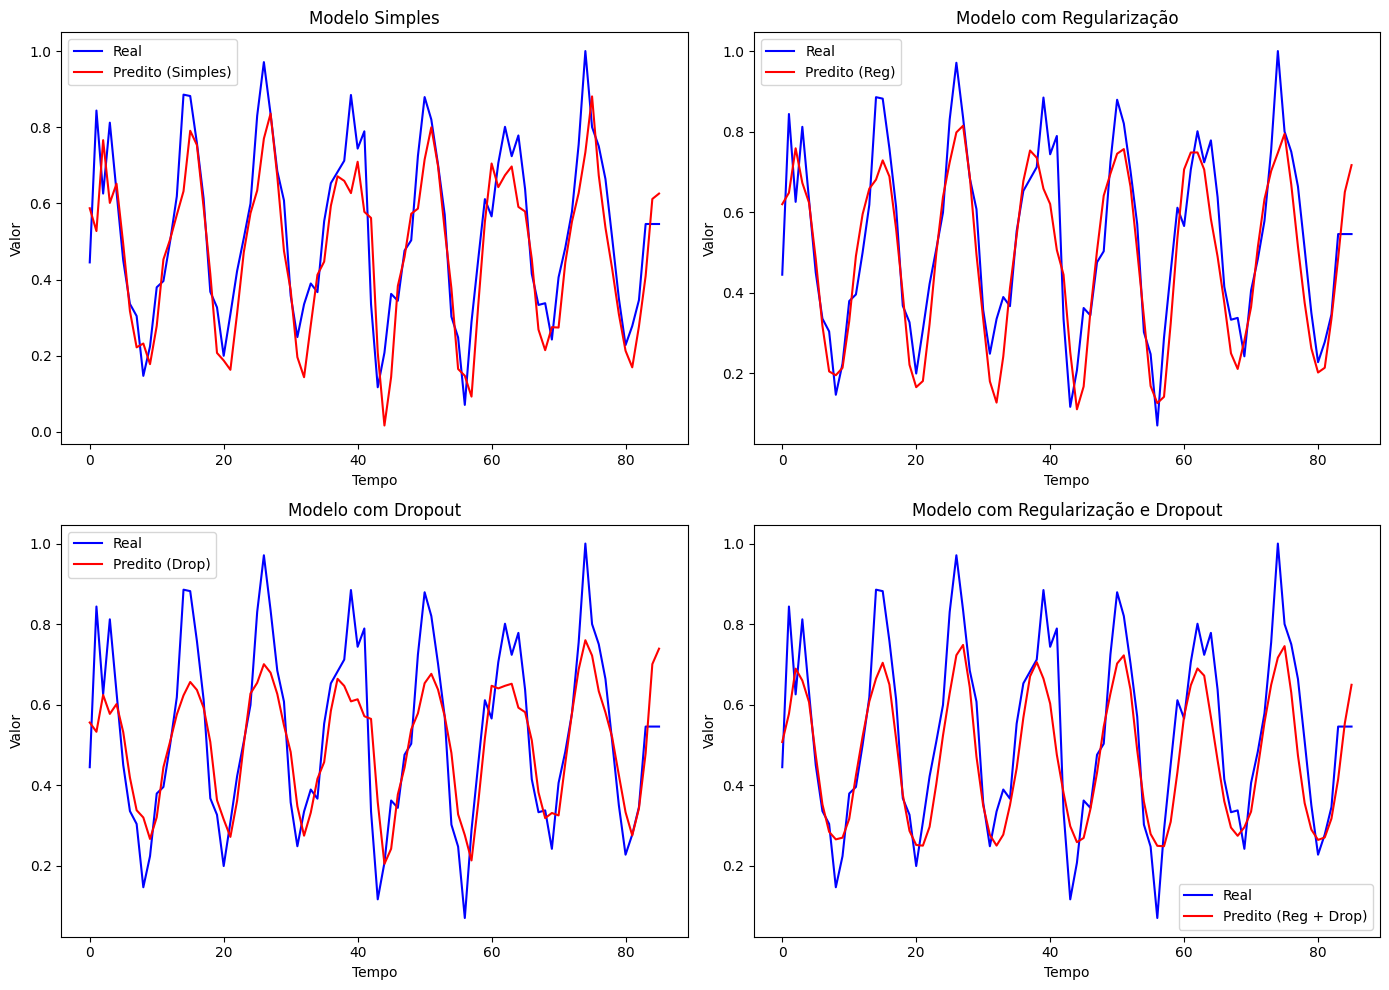

In [59]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


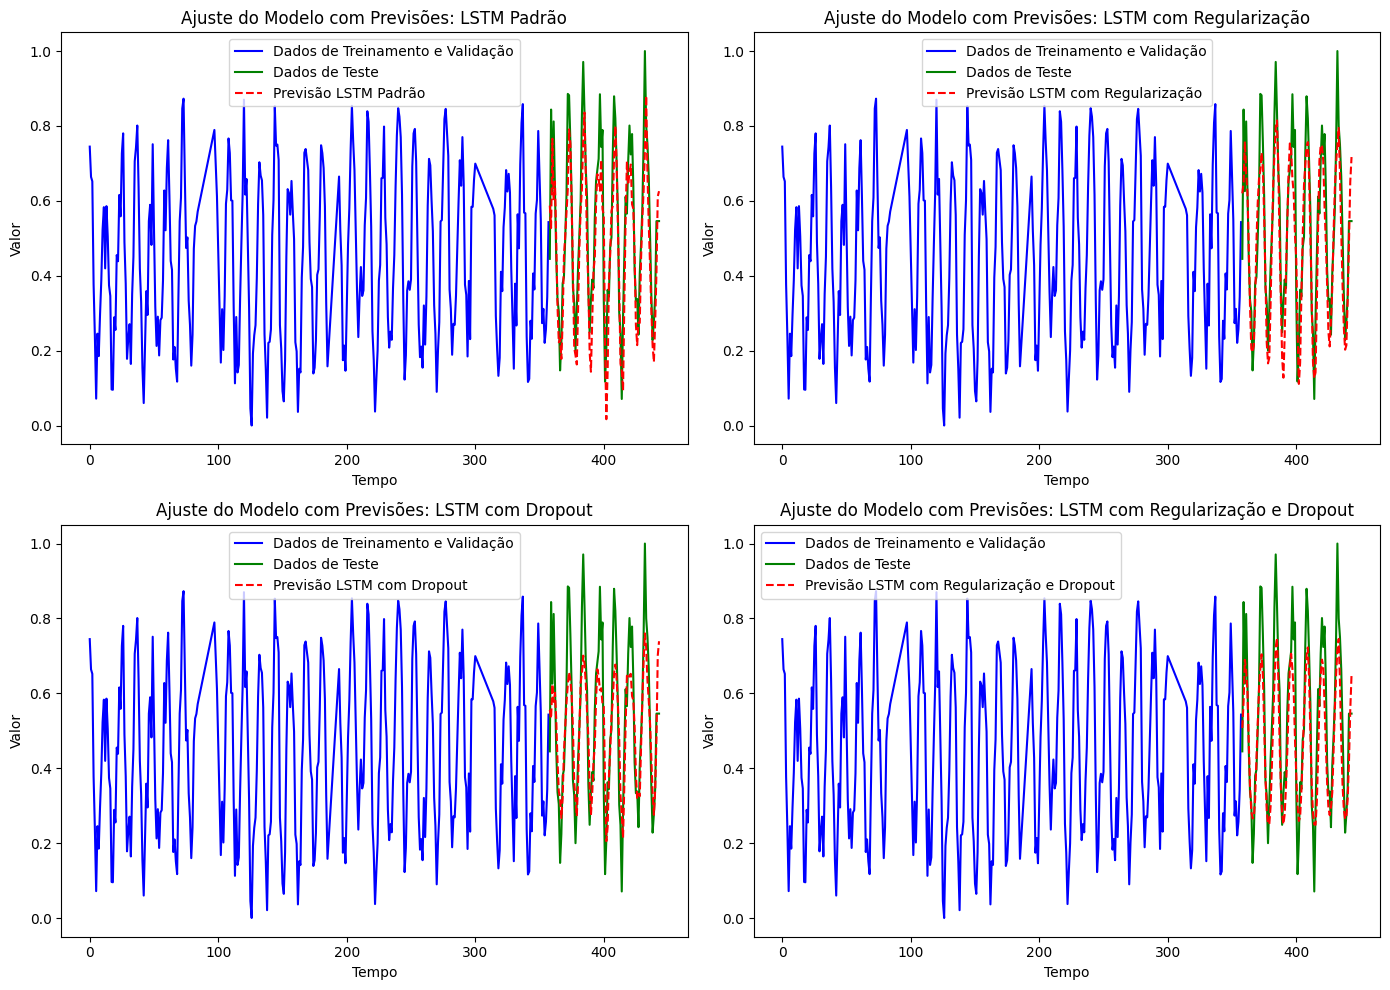

In [60]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [ ]:
#Hiperparametros
epochs_hibrid = 30
batch = 32
lr = 0.001

In [62]:
subsequences = 2
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (334, 2, 30, 1)
Validation set shape (24, 2, 30, 1)
Test set shape (86, 2, 30, 1)


## Implementacao e ajuste do modelo padrao

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam())

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, 
                                      Y_train, 
                                      validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=epochs_hibrid, 
                                      verbose=2)

## Implementacao e Ajuste do modelo com Regularizacao

In [ ]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs_hibrid, verbose=2)


## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(50, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs_hibrid, verbose=2)


## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [ ]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs_hibrid, verbose=2)


## Comparativo entre os modelos

In [ ]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn_lstm.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


In [ ]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo LSTM": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm)
    },
    "Modelo LSTM com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg)
    },
    "Modelo LSTM com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_drop)
    },
    "Modelo LSTM com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg_drop),
        "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop),
        "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop)
    }
}

# Adicionar a acurácia com base no MAPE
for model, values in metrics.items():
    values["Acurácia"] = 100 - values["MAPE"]  # Calcula a acurácia como 100 - MAPE

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}, Acurácia={values['Acurácia']:.2f}%")

In [ ]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)